In [1]:
import pandas as pd
from statsmodels.stats.contingency_tables import cochrans_q
import numpy as np
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import matplotlib

In [2]:
THRESHOLD = 0.05 #alpha significance level
tasks = {
    'binary': [0, 1], 
    'type': [0, 1, 2, 3]
}
representations = ['bow', 'freq', 'tfidf']
models = ['decision-tree', 'svm', 'naive-bayes', 'naive-bayes-multinomial']

In [3]:
#find the mode of a numpy array
def mode(array):
    freq = np.bincount(array)
    return np.argmax(freq)

In [4]:
def shorten_name(name):
    shortenings = {
    'decision-tree': 'dt',
    'naive-bayes-multinomial': 'nbm',
    'naive-bayes': 'nb',
    '-classification': '',
    '-type_of_antisemitism': '',}
    for long_version in shortenings:
        name = name.replace(long_version, shortenings[long_version])
    return name

#visualize the results of a post-hoc dunn analysis on a cochran's q test using matplotlib in a matrix
def visualize_dunn(dunn_values, names):
    names = [shorten_name(name) for name in names]
    
    plt.matshow(dunn_values)
    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_xticklabels(labels=names,rotation=90)
    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_yticklabels(labels=names)
    
    #pulled these next two lines from stack overflow, just to display the values
    for (i, j), z in np.ndenumerate(dunn_values):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
        
    plt.pause(0.1)

In [5]:
#combine columns in a dataframe whose names contain certain substrings
def combine_columns(df, substrings):
    '''
    df: the input dataframe that has many column names that contain certain common substrings
    substrings: the list of substrings used for combination
    
    returns: `output_df`, a DataFrame with `substrings` as its columns. Each row is the mode
    of the value for that row of all of the columns in `df` that contained that substring.
    '''
    output_df = pd.DataFrame()
    
    for column_substring in substrings:
        temp_df = pd.DataFrame()
        to_be_combined = [column for column in df.columns.values if column_substring in column]
        
        for column in to_be_combined:
            temp_df[column] = df[column]
            
        array = np.array(temp_df).astype(int)
        array = [mode(row) for row in array]
            
        output_df[column_substring] = array
    
    return output_df

In [6]:
#find which models performed best using basic accuracy score
def evaluate_models(df, substrings):
    output_df = pd.DataFrame()
    temp_df = combine_columns(df, substrings)
    for column in substrings:
        temp_df[column] = temp_df[column] == df['Actual']
        output_df[column] = [sum(temp_df[column])/len(temp_df),]
    output_df.index = ['Score']
    if 'index' in output_df.columns.values: del output_df['index']
    return output_df

#test model significance difference w/ Friedman Chi^2 while combining certain columns
def test_model_difference(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    cochran_result = cochrans_q(columns)
    return cochran_result

def post_hoc_tests(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    p_values = sp.posthoc_dunn(columns)
    return p_values

In [7]:
#get a list of binary dfs of whether or not they fit with a particular classification
def get_dfs(df, classifications):
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    return dfs

#find specific rankings for each model
def overall_evaluation(task, classifications):
    df = pd.read_csv(f'{task}_predictions.csv')
    score_df = pd.DataFrame()
    dfs = get_dfs(df, classifications)
        
    for (i, temp_df) in enumerate(dfs):
        temp_df = evaluate_models(temp_df, temp_df.columns.values).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
            
        score_df[f'Score {i}'] = temp_df['Score']
    
    score_df['Mean score'] = score_df.mean(axis=1)
    score_df = score_df.sort_values('Mean score', ascending = False)
    cochran_result = cochrans_q(df)
    post_hoc_p = pd.DataFrame()
    if cochran_result.pvalue <= THRESHOLD:
        post_hoc_p = post_hoc_tests(df, df.columns.values)
    
    print(f'Task: {task}.')
    print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
    if cochran_result.pvalue <= THRESHOLD:
        print('Post-hoc Dunn test array:')
        visualize_dunn(post_hoc_p, df.columns.values)
    
    score_df.index = [shorten_name(name) for name in score_df.index]
    print(score_df)
    print(f'\nMean: {score_df["Mean score"].mean()}')
    print('\n\n')

In [8]:
def evaluate_rep_model(grouping, dfs):
    final_df = pd.DataFrame()
    
    for i, df in enumerate(dfs):
        temp_df = evaluate_models(df, grouping).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
        
        temp_df.columns = ['Score']
        final_df[f'Score {i}'] = temp_df['Score']
        
    return final_df

#evaluate algorithms and representations, find significance level
def algorithm_and_rep_eval(task, classifications):
    df = pd.read_csv(f'{task}_predictions.csv')
    for column in [column for column in df.columns.values if 'BERT' in column]:
        del df[column]
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    for grouping in [representations, models]:
        score_df = evaluate_rep_model(grouping, dfs)
        score_df['Mean score'] = score_df.mean(axis=1)
        score_df = score_df.sort_values('Mean score', ascending = False)
        
        combined_df = combine_columns(df, grouping)
        cochran_result = cochrans_q(combined_df)
        if cochran_result.pvalue <= THRESHOLD:
            post_hoc_p = post_hoc_tests(combined_df, grouping)
        
        print(f'Task: {task}. Grouping: {grouping}.')
        print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
        if cochran_result.pvalue <= THRESHOLD:
            print('Post-hoc Dunn test array:')
            visualize_dunn(post_hoc_p, grouping)
        
        score_df.index = [shorten_name(name) for name in score_df.index]
        print(f"Scores: \n{score_df}")
        print(f'\nMean: {score_df["Mean score"].mean()}')
        print('\n\n\n\n')

The below visualizations and `DataFrame`s contain testing information on the various algorithms and representation methods used to create models. Data is shown on two tasks, 'binary,' referring to the binary classification of whether or not a particular tweet is antisemitic, and 'type,' referring to classifying the tweet with a particular type of antisemitism. The model evaluation was done in two stages, first the overall evaluation, then the grouped evaluation for different algorithms and representations. Some names are shortened during presentation: `decision-tree` is shortened to `dt`, `naive-bayes-multinomial` to `nbm`, and `naive-bayes` to `nb`.

For the overall evaluation, the model scores were generated using the arithmetic mean of the recalls on each individual class, with a Cochran's Q test being performed on a matrix that contained columns for each model and in each column contained a `1` where the model found the correct answer, and `0` where the model found the incorrect answer. Then, if the Q test found an *p*-value lower than the specified global `THRESHOLD` constant, it performs a post-hoc Dunn text, which is then visualized in the form of a matrix, with higher values meaning lighter colors and a greater correlation between two models' answers. Then, the score `DataFrame` is shown, with a column entitled `Mean score` for the arithmetic mean of the recall of the model on each class. There are additional columns entitles `Score {x}`, with `{x}` being the specific class that that column gives the recall of for each model. Finally, an overall mean of the `Mean score` column is given.

For the model grouping evaluation, models are grouped into classes either by their representation or algorithm type. The most common answer across all models of this type is then taken as the answer for this grouping. Following this, the same process as above was used.


Task: Binary

Task: binary.
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


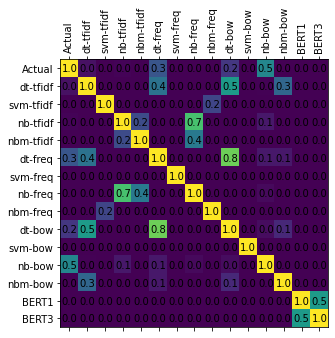

            Score 0   Score 1  Mean score
Actual     1.000000  1.000000    1.000000
dt-freq    0.834475  0.508721    0.671598
dt-tfidf   0.844749  0.479651    0.662200
svm-bow    0.916667  0.401163    0.658915
dt-bow     0.824201  0.465116    0.644659
nbm-bow    0.845890  0.421512    0.633701
svm-freq   0.963470  0.226744    0.595107
nbm-tfidf  0.687215  0.441860    0.564538
nb-bow     0.732877  0.366279    0.549578
nb-freq    0.683790  0.380814    0.532302
nb-tfidf   0.688356  0.369186    0.528771
svm-tfidf  0.992009  0.058140    0.525074
BERT1      0.535388  0.505814    0.520601
nbm-freq   1.000000  0.000000    0.500000
BERT3      0.506849  0.470930    0.488890

Mean: 0.6050622101872499



Task: binary. Grouping: ['bow', 'freq', 'tfidf'].
Cochran's Q test p-value: 6.802542093249886e-30
Post-hoc Dunn test array:


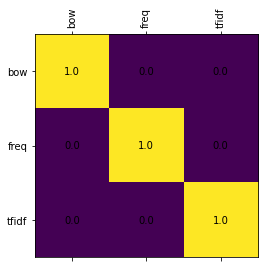

Scores: 
        Score 0   Score 1  Mean score
bow    0.937215  0.337209    0.637212
tfidf  0.964612  0.194767    0.579690
freq   0.982877  0.113372    0.548124

Mean: 0.5883420055927224





Task: binary. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'naive-bayes-multinomial'].
Cochran's Q test p-value: 9.562951163046139e-36
Post-hoc Dunn test array:


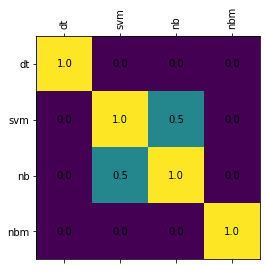

Scores: 
      Score 0   Score 1  Mean score
dt   0.858447  0.497093    0.677770
nbm  0.876712  0.311047    0.593879
svm  0.963470  0.215116    0.589293
nb   0.882420  0.247093    0.564757

Mean: 0.6064248831899756






Task: Type

Task: type.
Cochran's Q test p-value: 9.092135740003686e-88
Post-hoc Dunn test array:


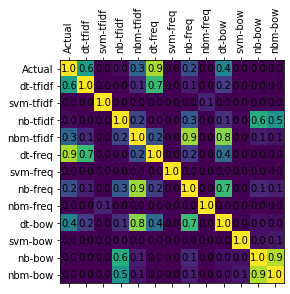

            Score 0  Score 1   Score 2   Score 3  Mean score
Actual     1.000000    1.000  1.000000  1.000000    1.000000
dt-bow     0.658824    0.375  0.282051  0.447154    0.440757
dt-tfidf   0.629412    0.000  0.410256  0.569106    0.402193
dt-freq    0.629412    0.000  0.358974  0.504065    0.373113
nbm-tfidf  0.705882    0.000  0.230769  0.552846    0.372374
nbm-bow    0.811765    0.000  0.128205  0.495935    0.358976
nb-freq    0.647059    0.000  0.230769  0.479675    0.339376
svm-bow    0.894118    0.000  0.000000  0.398374    0.323123
nb-tfidf   0.676471    0.000  0.128205  0.439024    0.310925
nb-bow     0.664706    0.000  0.153846  0.414634    0.308297
svm-freq   0.905882    0.000  0.000000  0.227642    0.283381
nbm-freq   1.000000    0.000  0.000000  0.000000    0.250000
svm-tfidf  0.941176    0.000  0.000000  0.040650    0.245457

Mean: 0.3852286249324379



Task: type. Grouping: ['bow', 'freq', 'tfidf'].
Cochran's Q test p-value: 8.75986791683429e-10
Post-hoc Dunn test arr

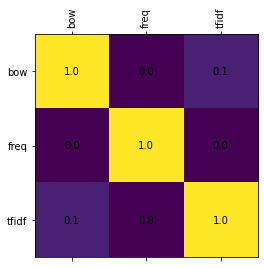

Scores: 
        Score 0  Score 1   Score 2   Score 3  Mean score
bow    0.911765      0.0  0.128205  0.382114    0.355521
tfidf  0.888235      0.0  0.128205  0.300813    0.329313
freq   0.952941      0.0  0.051282  0.121951    0.281544

Mean: 0.3221259610786153





Task: type. Grouping: ['decision-tree', 'svm', 'naive-bayes', 'naive-bayes-multinomial'].
Cochran's Q test p-value: 2.6564876986034537e-20
Post-hoc Dunn test array:


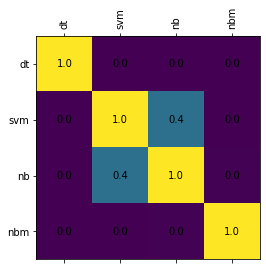

Scores: 
      Score 0  Score 1   Score 2   Score 3  Mean score
dt   0.647059      0.0  0.358974  0.552846    0.389720
nbm  0.888235      0.0  0.076923  0.439024    0.351046
nb   0.835294      0.0  0.128205  0.349593    0.328273
svm  0.929412      0.0  0.000000  0.203252    0.283166

Mean: 0.3380511257035647







In [9]:
for task in tasks:
    print(f'\nTask: {task.title()}\n')
    overall_evaluation(task, tasks[task]) #find the rankings for all models
    algorithm_and_rep_eval(task, tasks[task]) #group representations and algorithms together, evaluate